In [ ]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2024-11-26 02:53:30--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.207, 74.125.202.207, 74.125.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   215MB/s    in 0.3s    

2024-11-26 02:53:30 (215 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
!unzip cats_and_dogs_filtered.zip

Archive:  cats_and_dogs_filtered.zip
replace cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: cats_and_dogs_filtered/vectorize.py  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2118.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2117.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2116.jpg  
  inflating: cats_and_d

In [ ]:
!ls

cats_and_dogs_filtered	cats_and_dogs_filtered.zip  sample_data


In [ ]:
!ls cats_and_dogs_filtered/train

cats  dogs


In [ ]:
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score
import torch.utils
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Operations for transforming images and turning them into tensors
transform_train = transforms.Compose(
    [
        transforms.Resize((50, 50)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

transform_val = transforms.Compose(
    [
        transforms.Resize((50, 50)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [ ]:
train_data = datasets.ImageFolder("cats_and_dogs_filtered/train", transform=transform_train)
test_data = datasets.ImageFolder("cats_and_dogs_filtered/validation/", transform=transform_val)

In [ ]:
train_data

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: cats_and_dogs_filtered/train
    StandardTransform
Transform: Compose(
               Resize(size=(50, 50), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
# Creating loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

In [ ]:
images.shape, labels.shape

(torch.Size([32, 3, 50, 50]), torch.Size([32]))

In [ ]:
# Plotting images
def show_images(imgs, labels):
    fig, axes = plt.subplots(1, 10, figsize=(30, 5))

    for i, axis in enumerate(axes):
        axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap="gray")
        axes[i].set_title(labels[i].numpy())

    plt.show()

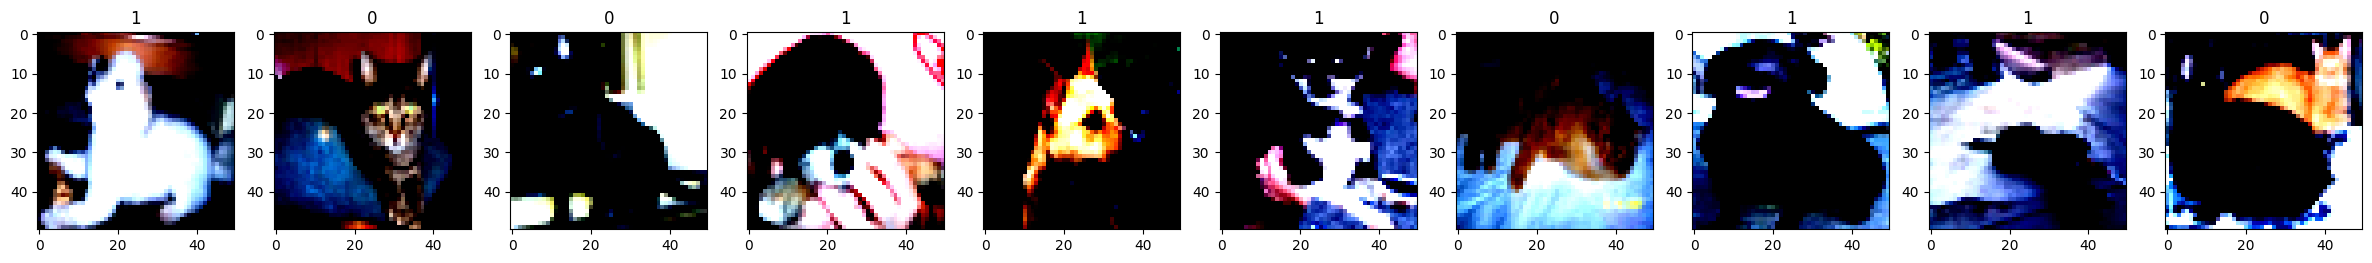

In [ ]:
show_images(images, labels)

# **Base CNN training**

In [ ]:
class Flatten(nn.Module):
  def forward(self, input):
    return input.view(input.size(0), -1)

class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 10, kernel_size=3)
    self.mp1 = nn.MaxPool2d((2, 2))
    self.conv2 = nn.Conv2d(10, 3, kernel_size=3)

    self.flatten = Flatten()
    self.fc1 = nn.Linear(1452, 256)
    self.fc2 = nn.Linear(256, 2)

  def forward(self, x):
    # Multiply by weight matrix of the 1st layer and applying activation function
    x = F.relu(self.conv1(x))
    x = self.mp1(x)
    x = F.relu(self.conv2(x))
    x = self.flatten(x)
    # Multiply by weight matrix of the 2nd layer and applying activation function
    x = F.relu(self.fc1(x))
    x = F.softmax(self.fc2(x))

    return x

In [ ]:
def train(net, n_epoch=5):
  loss_func = torch.nn.CrossEntropyLoss()

  lr = 1e-3
  optimizer = torch.optim.Adam(net.parameters(), lr=lr)

  for epoch in tqdm_notebook(range(n_epoch)):
    running_loss = 0.0
    train_dataiter = iter(train_loader)

    for i, batch in enumerate(tqdm_notebook(train_dataiter)):
      # Getting current batch
      X_batch, y_batch = batch

      # Reset weights
      optimizer.zero_grad()

      y_pred = net(X_batch)
      # Counting loss
      loss = loss_func(y_pred, y_batch)
      # Back propagation
      loss.backward()
      # Update weights
      optimizer.step()

      # Current loss
      running_loss += loss.item()

      if i % 10 == 9:
        print("[%d, %5d] loss: %.3f, acc: %3f" % (epoch + 1, i + 1, running_loss / 500, accuracy_score(y_batch.numpy(), np.argmax(y_pred.detach().numpy(), axis=1))))
        running_loss = 0.0

  print("Training is complete")
  return net

In [ ]:
# Initialization
net = ConvNet()
# Training
net = train(net)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

[1,    10] loss: 0.014, acc: 0.500000
[1,    20] loss: 0.014, acc: 0.531250
[1,    30] loss: 0.014, acc: 0.562500
[1,    40] loss: 0.013, acc: 0.531250
[1,    50] loss: 0.014, acc: 0.500000
[1,    60] loss: 0.014, acc: 0.531250


  0%|          | 0/63 [00:00<?, ?it/s]

[2,    10] loss: 0.013, acc: 0.625000
[2,    20] loss: 0.013, acc: 0.718750
[2,    30] loss: 0.013, acc: 0.500000
[2,    40] loss: 0.013, acc: 0.625000
[2,    50] loss: 0.013, acc: 0.625000
[2,    60] loss: 0.013, acc: 0.812500


  0%|          | 0/63 [00:00<?, ?it/s]

[3,    10] loss: 0.012, acc: 0.781250
[3,    20] loss: 0.012, acc: 0.687500
[3,    30] loss: 0.012, acc: 0.812500
[3,    40] loss: 0.012, acc: 0.687500
[3,    50] loss: 0.012, acc: 0.593750
[3,    60] loss: 0.012, acc: 0.718750


  0%|          | 0/63 [00:00<?, ?it/s]

[4,    10] loss: 0.012, acc: 0.656250
[4,    20] loss: 0.011, acc: 0.781250
[4,    30] loss: 0.011, acc: 0.812500
[4,    40] loss: 0.011, acc: 0.687500
[4,    50] loss: 0.011, acc: 0.812500
[4,    60] loss: 0.012, acc: 0.687500


  0%|          | 0/63 [00:00<?, ?it/s]

[5,    10] loss: 0.011, acc: 0.718750
[5,    20] loss: 0.010, acc: 0.812500
[5,    30] loss: 0.011, acc: 0.750000
[5,    40] loss: 0.010, acc: 0.843750
[5,    50] loss: 0.012, acc: 0.750000
[5,    60] loss: 0.011, acc: 0.687500
Training is complete


In [ ]:
# Calculating accuracy on test data
test_dataiter = iter(test_loader)
images, labels = test_dataiter.__next__()

In [ ]:
accuracy_score(labels.numpy(), np.argmax(net.forward(images).detach().numpy(), axis=1))

0.625

# **VGG16 additional training**

In [ ]:
vgg16 = models.vgg16(pretrained=True)

In [ ]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
vgg16.classifier = nn.Sequential(*list(vgg16.classifier.children()))[:-1]

In [ ]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
class New_VGG16(nn.Module):
  def __init__(self):
    super().__init__()
    self.vgg16 = vgg16

    for param in self.vgg16.features.parameters():
      param.requires_grad = False

    self.fc = nn.Linear(4096, 2)

  def forward(self, x):
    # Multiply by weight matrix of the 1st layer and applying activation function
    x = self.vgg16(x)
    x = self.fc(x)

    return x

In [ ]:
# Initialization
net = New_VGG16()
# Training
train(net)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

[1,    10] loss: 0.040, acc: 0.906250
[1,    20] loss: 0.036, acc: 0.687500
[1,    30] loss: 0.038, acc: 0.750000
[1,    40] loss: 0.034, acc: 0.781250
[1,    50] loss: 0.032, acc: 0.875000
[1,    60] loss: 0.022, acc: 0.718750


  0%|          | 0/63 [00:00<?, ?it/s]

[2,    10] loss: 0.010, acc: 0.843750
[2,    20] loss: 0.016, acc: 0.750000
[2,    30] loss: 0.016, acc: 0.625000
[2,    40] loss: 0.021, acc: 0.843750
[2,    50] loss: 0.013, acc: 0.812500
[2,    60] loss: 0.013, acc: 0.875000


  0%|          | 0/63 [00:00<?, ?it/s]

[3,    10] loss: 0.017, acc: 0.750000
[3,    20] loss: 0.014, acc: 0.812500
[3,    30] loss: 0.023, acc: 0.718750
[3,    40] loss: 0.014, acc: 0.875000
[3,    50] loss: 0.020, acc: 0.812500
[3,    60] loss: 0.014, acc: 0.750000


  0%|          | 0/63 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
test_dataiter = iter(test_loader)
images, labels = test_dataiter.__next__()

In [ ]:
accuracy_score(labels.numpy(), np.argmax(net.forward(images).detach().numpy(), axis=1))

0.875